In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, shutil
ROOT_PROJECT =  os.path.join(os.path.normpath(os.path.join(os.getcwd(), "../")))
sys.path[0] = ROOT_PROJECT

import numpy as np
import os, glob
# import seaborn as sns

import matplotlib
from matplotlib import colors, colorbar
from matplotlib import cm
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats, clear_output

import matplotlib_inline.backend_inline
ipython_format = "retina"
if isinstance(ipython_format, str):
    ipython_format = [ipython_format]
matplotlib_inline.backend_inline.set_matplotlib_formats(*ipython_format)

# plt.style.use('seaborn-whitegrid')
plt.style.use('science')
plt.rcParams['figure.figsize'] = (12.0, 7.0)

from tqdm import tqdm

In [2]:
plt.plot()
plt.close()

In [3]:
import warnings
# warnings.simplefilter("ignore", UserWarning)

import torch

from mcbo import RESULTS_DIR

from mcbo.utils.general_utils import plot_mean_std

from mcbo.factory import task_factory
from mcbo.utils.experiment_utils import run_experiment, get_opt_results, get_bo_short_opt_id

import seaborn as sns
from matplotlib.ticker import FixedLocator
from mcbo.utils.general_plot_utils import plot_curves_with_ranked_legends, COLORS, MARKERS, plot_task_regrets

from typing import *
import pandas as pd

In [4]:
from mcbo.optimizers import RandomSearch, HillClimbing, \
    SimulatedAnnealing, GeneticAlgorithm, BoBuilder
from mcbo.optimizers.bo_builder import BO_ALGOS

from analysis.model_fit.model_fit import get_fit_result_dir
from mcbo.utils.experiment_utils import get_opt, get_task_from_id
from mcbo.optimizers.bo_builder import BoBuilder
from mcbo.utils.general_utils import load_w_pickle
dtype: torch.dtype = torch.float64

In [5]:
import scikit_posthocs as sp
import scipy.stats as stats

In [6]:
figure_save_name = "figure_mcbo_mixed"
data_save_name = "data_mcbo_mixed"

os.makedirs(f"./{figure_save_name}", exist_ok=True)
os.makedirs(f"./{data_save_name}", exist_ok=True)

In [7]:
ALL_RES_MIX_PATH = f"./{data_save_name}/all_res_mix.csv"

In [8]:
task_ids = ["ackley-53", "xgboost_opt", "aig_optimization_hyp", "svm_opt"]

model_ids = ["gp_o", "gp_to", "gp_hed"]
acq_opts = ["is", "sa", "ga", "mab"]
tr_ids = [None, "basic"]

non_bo_short_ids = ["ga", "rs", "sa", "hc"]

seeds = np.arange(42, 57)

In [9]:
# get aliases

MIXED_BO_ALGO = ["Casmopolitan", "BODi", "CoCaBO"]
BO_ALGO_FULL_NAME_TO_ALIAS = {}
BO_ALGO_ALIAS_TO_FULL_NAME = {}

task = get_task_from_id(task_id=task_ids[0])
search_space = task.get_search_space()

for alias in MIXED_BO_ALGO:
    bo_algo_builder = BO_ALGOS[alias]
    opt = bo_algo_builder.build_bo(
        search_space=search_space,
        n_init=20,
        input_constraints=task.input_constraints,
    )
    BO_ALGO_FULL_NAME_TO_ALIAS[opt.name] = alias
    BO_ALGO_ALIAS_TO_FULL_NAME[alias] = opt.name    
    
NON_BO_ALGO_NAMES = []
for non_bo_short_id in non_bo_short_ids:
    opt = get_opt(task=task, short_opt_id=non_bo_short_id)
    NON_BO_ALGO_NAMES.append(opt.name)

In [10]:
all_res = None

if os.path.exists(ALL_RES_MIX_PATH):
    all_res = pd.read_csv(ALL_RES_MIX_PATH, index_col=0)
else:
    for t in range(len(task_ids)):
        task_id = task_ids[t]
        for m in range(len(model_ids)):
            for a in range(len(acq_opts)):
                for r in range(len(tr_ids)):
                    model_id = model_ids[m]
                    acq_opt_id = acq_opts[a]
                    tr_id = tr_ids[r]

                    if model_id == "lr_sparse_hs":
                        acq_func_id = "ts" 
                    else:
                        acq_func_id = "ei" 

                    opt_short_id = get_bo_short_opt_id(model_id=model_id, acq_opt_id=acq_opt_id, acq_func_id=acq_func_id, tr_id=tr_id)

                    results = get_opt_results(task_id=task_id, opt_short_name=opt_short_id, seeds=seeds)

                    if all_res is None:
                        all_res = results
                    else:
                        all_res = pd.concat([all_res, results], ignore_index=True)
        for non_bo_short_name in non_bo_short_ids:
            results = get_opt_results(task_id=task_id, opt_short_name=non_bo_short_name, seeds=seeds)

            if all_res is None:
                all_res = results
            else:
                all_res = pd.concat([all_res, results], ignore_index=True)
    all_res.to_csv(ALL_RES_MIX_PATH)

In [11]:
all_res.head()

,Task,Optimizer,Model,Acq opt,Acq func,TR,Seed,Eval Num,f(x),f(x*),Elapsed Time
0,Ackley Function 50-nom-2 3-num,GP (mat52 and O) - IS acq optim,GP (mat52 and O),IS,EI,no-tr,42,1,2.807968,2.807968,0.030742
1,Ackley Function 50-nom-2 3-num,GP (mat52 and O) - IS acq optim,GP (mat52 and O),IS,EI,no-tr,42,2,2.872459,2.807968,0.059591
2,Ackley Function 50-nom-2 3-num,GP (mat52 and O) - IS acq optim,GP (mat52 and O),IS,EI,no-tr,42,3,2.822870,2.807968,0.088582
3,Ackley Function 50-nom-2 3-num,GP (mat52 and O) - IS acq optim,GP (mat52 and O),IS,EI,no-tr,42,4,2.779389,2.779389,0.117990
4,Ackley Function 50-nom-2 3-num,GP (mat52 and O) - IS acq optim,GP (mat52 and O),IS,EI,no-tr,42,5,2.772162,2.772162,0.146278


In [15]:
print(f"Number of novel algos: {len(all_res.Optimizer.unique()) - len(MIXED_BO_ALGO) - len(non_bo_short_ids)}")
print(f"Number of optimization runs: {len(all_res) // max(all_res['Eval Num'])}")

Number of novel algos: 21
Number of optimization runs: 1680


### Get rank of mean performance per task

In [25]:
TR_ALIAS_TO_NAME = {
    "no-tr": "W/O TR",
    "turbo": "W/ TR",
    "basic": "W/ TR"
}

ACQ_OPT_ALIAS_TO_NAME = {
    "IS": "HC-GD",
    "MAB-sgd": "MAB-GD"
}

def acq_func_alias_to_name(acq_opt: str) -> str:
    if acq_opt in ACQ_OPT_ALIAS_TO_NAME:
        return ACQ_OPT_ALIAS_TO_NAME[acq_opt]
    return acq_opt

In [26]:
def data_key_to_label(k: str):
    if k in BO_ALGO_FULL_NAME_TO_ALIAS:
        k = BO_ALGO_FULL_NAME_TO_ALIAS[k]
    else:
        k = k
    if k == "IS":
        return "HC-GD"
    k = k.replace("MAB-sgd", "MAB-GD")
    k = k.replace("- IS", "- HC-GD")
    k = k.replace("HED-mat52", "HED")
    k = k.replace("Diffusion", "Diff.")
    k = k.replace("turbo", "w/ TR")
    k = k.replace("basic", "w/ TR")
    k = k.replace("no-tr", "w/o TR")
    k = k.replace("IS acq optim", "HC-GD acq optim")
    k = k.replace("mat52 and ", "mat. 5/2 - ")
    k = k.replace("Tr-based GA acq optim", "GA w/ TR")
    return k

In [27]:
x_fontsize = 15
y_fontsize = 15
y_label_fontsize = 22
x_label_fontsize = 17

xticks_labels_size = 14
yticks_labels_size = 14

legend_fontsize = 18
ax_title_fontsize = 20

In [28]:
final_num_eval = 200

all_opt_to_rank_dicts = {}

For each task and seed, rank the optimizers.

In [29]:
sub_regret_df = all_res.copy()

sub_regret_df["rank"] = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])[["f(x*)"]].rank()
sub_regret_df.head()

,Task,Optimizer,Model,Acq opt,Acq func,TR,Seed,Eval Num,f(x),f(x*),Elapsed Time,rank
0,Ackley Function 50-nom-2 3-num,GP (mat52 and O) - IS acq optim,GP (mat52 and O),IS,EI,no-tr,42,1,2.807968,2.807968,0.030742,12.5
1,Ackley Function 50-nom-2 3-num,GP (mat52 and O) - IS acq optim,GP (mat52 and O),IS,EI,no-tr,42,2,2.872459,2.807968,0.059591,14.5
2,Ackley Function 50-nom-2 3-num,GP (mat52 and O) - IS acq optim,GP (mat52 and O),IS,EI,no-tr,42,3,2.822870,2.807968,0.088582,14.5
3,Ackley Function 50-nom-2 3-num,GP (mat52 and O) - IS acq optim,GP (mat52 and O),IS,EI,no-tr,42,4,2.779389,2.779389,0.117990,15.5
4,Ackley Function 50-nom-2 3-num,GP (mat52 and O) - IS acq optim,GP (mat52 and O),IS,EI,no-tr,42,5,2.772162,2.772162,0.146278,15.5


##### For each optimizer, average rank per task, and average these across all tasks to get the overall rank performance of each optimizer at the end of the optimization

In [30]:
algo_name_to_avg_rank = sub_regret_df[sub_regret_df["Eval Num"] == final_num_eval].groupby(["Optimizer"])["rank"].mean().to_dict()

##### Keep the 2 best mixed and match algorithm, the already published algorithm as well as the standard heuristics

In [31]:
best_unbranded_opt_names = sorted([k for k in algo_name_to_avg_rank if (k not in BO_ALGO_FULL_NAME_TO_ALIAS and k not in NON_BO_ALGO_NAMES)], key=lambda k: algo_name_to_avg_rank[k])

In [32]:
selected_algo_names = best_unbranded_opt_names[:2] + [k for k in BO_ALGO_FULL_NAME_TO_ALIAS.keys() if k in algo_name_to_avg_rank] + NON_BO_ALGO_NAMES

##### Show evolution of rank among them

In [33]:
from scipy.stats import rankdata

In [34]:
sub_regret_df = all_res[all_res.Optimizer.isin(selected_algo_names)].copy()
aux_group = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])
sub_regret_df["rank"] = aux_group[["f(x*)"]].rank()

counts = aux_group.count().values.flatten()
assert np.all(counts[0] == counts)

num_cands = counts[0]

In [35]:
num_evals = np.arange(20, 201)
group_col = "Optimizer"

opt_to_rank_dict = {}

sub_regret_df = sub_regret_df[sub_regret_df.Optimizer.isin(selected_algo_names)]

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["Eval Num"] == num_eval].groupby(group_col)["rank"]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T
all_opt_to_rank_dicts["None"] = opt_to_rank_dict.copy()

###### Assess statistical difference

In [36]:
eval_budget = 200
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["Eval Num"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["Task", "Seed"])["rank"]])

friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

if friedman_test_pvalue >= 0.05:
    print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col="rank",  group_col=group_col, zero_method="pratt") 

test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

In [37]:
data_color = {data_key: COLORS[i % len(COLORS)] for i, data_key in enumerate(opt_to_rank_dict)}
data_marker = {data_key: MARKERS[i % len(MARKERS)] for i, data_key in enumerate(opt_to_rank_dict)}

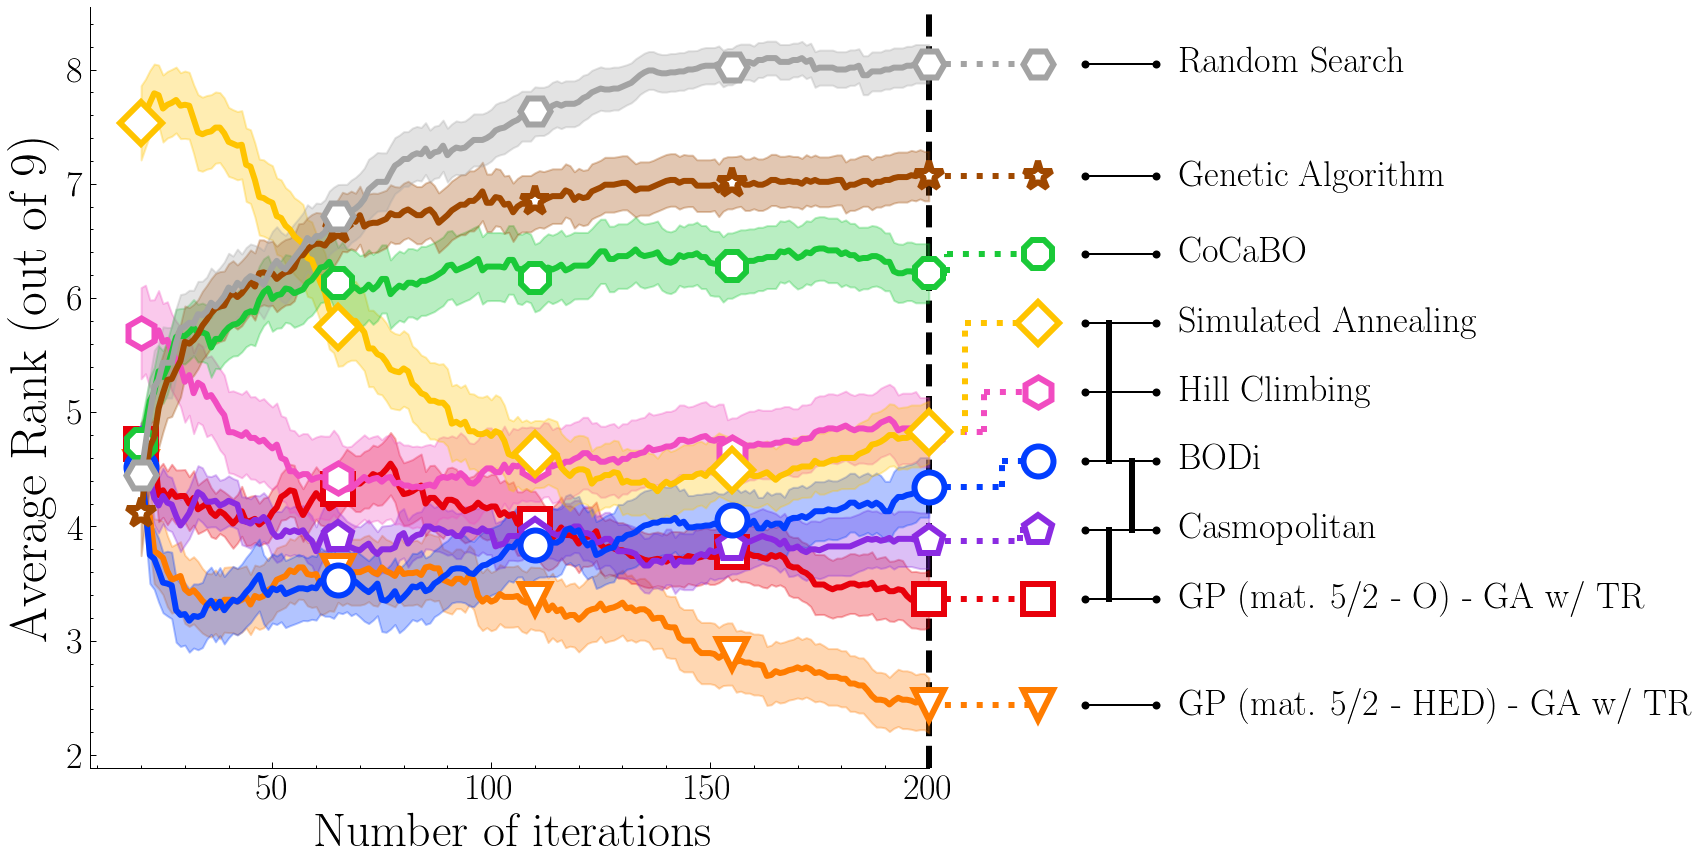

In [38]:
fig, ax = plt.subplots(figsize=(10, 7))

plot_curves_with_ranked_legends(
    ax=ax,
    data_y=opt_to_rank_dict,
    data_x=num_evals,
    show_std_error=True,
    min_is_the_best=True,
    data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map,
    data_color=data_color,
    data_marker=data_marker
)

ax.set_ylabel(f"Average Rank (out of {num_cands})", fontsize=26)
ax.set_xlabel("Number of iterations", fontsize=24)
ax.xaxis.set_label_coords(.38, -0.06)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.savefig(f"./{figure_save_name}/avg_rank.pdf")
plt.show()

The shaded area shows the standard error associted to the 10 seeds. Methods linked by a thick black vertical bars are methods whose final rank difference is smaller than the critical difference computed from Wilcoxon signed ranks test.

- On average, BO methods outperform heuristics and we see that new mix and match achieves lowest rank.

#### Show results of the selected optimizers on each task as evolution of regret

We now show the evolution of regrets on each subtask, we include the most competitive heuristics SA and GA and HC.

In [39]:
for to_remove_algo in ["Random Search"]:
    if to_remove_algo in selected_algo_names:
        selected_algo_names.remove(to_remove_algo)

In [40]:
TASK_ID_TO_NAME = {
    'Ackley Function 50-nom-2 3-num': 'Ackley-53D',
    'XGBoost Opt - mnist': "XGBoost - MNIST",
    'EDA Sequence Optimization - Design sin - Ops basic - Pattern basic_w_post_map - Hyps boils_hyp_op_space - Obj both': 'AIG Flow and Hyp. Tuning',
    'SVM Opt':r"$\nu$-SVR - Slice", 
}

def task_id_to_name(task_id: str) -> str:
    return TASK_ID_TO_NAME.get(task_id, task_id)

In [41]:
seeds = np.arange(42, 57)

x_evals = np.arange(0, 200)

ci_level = .95

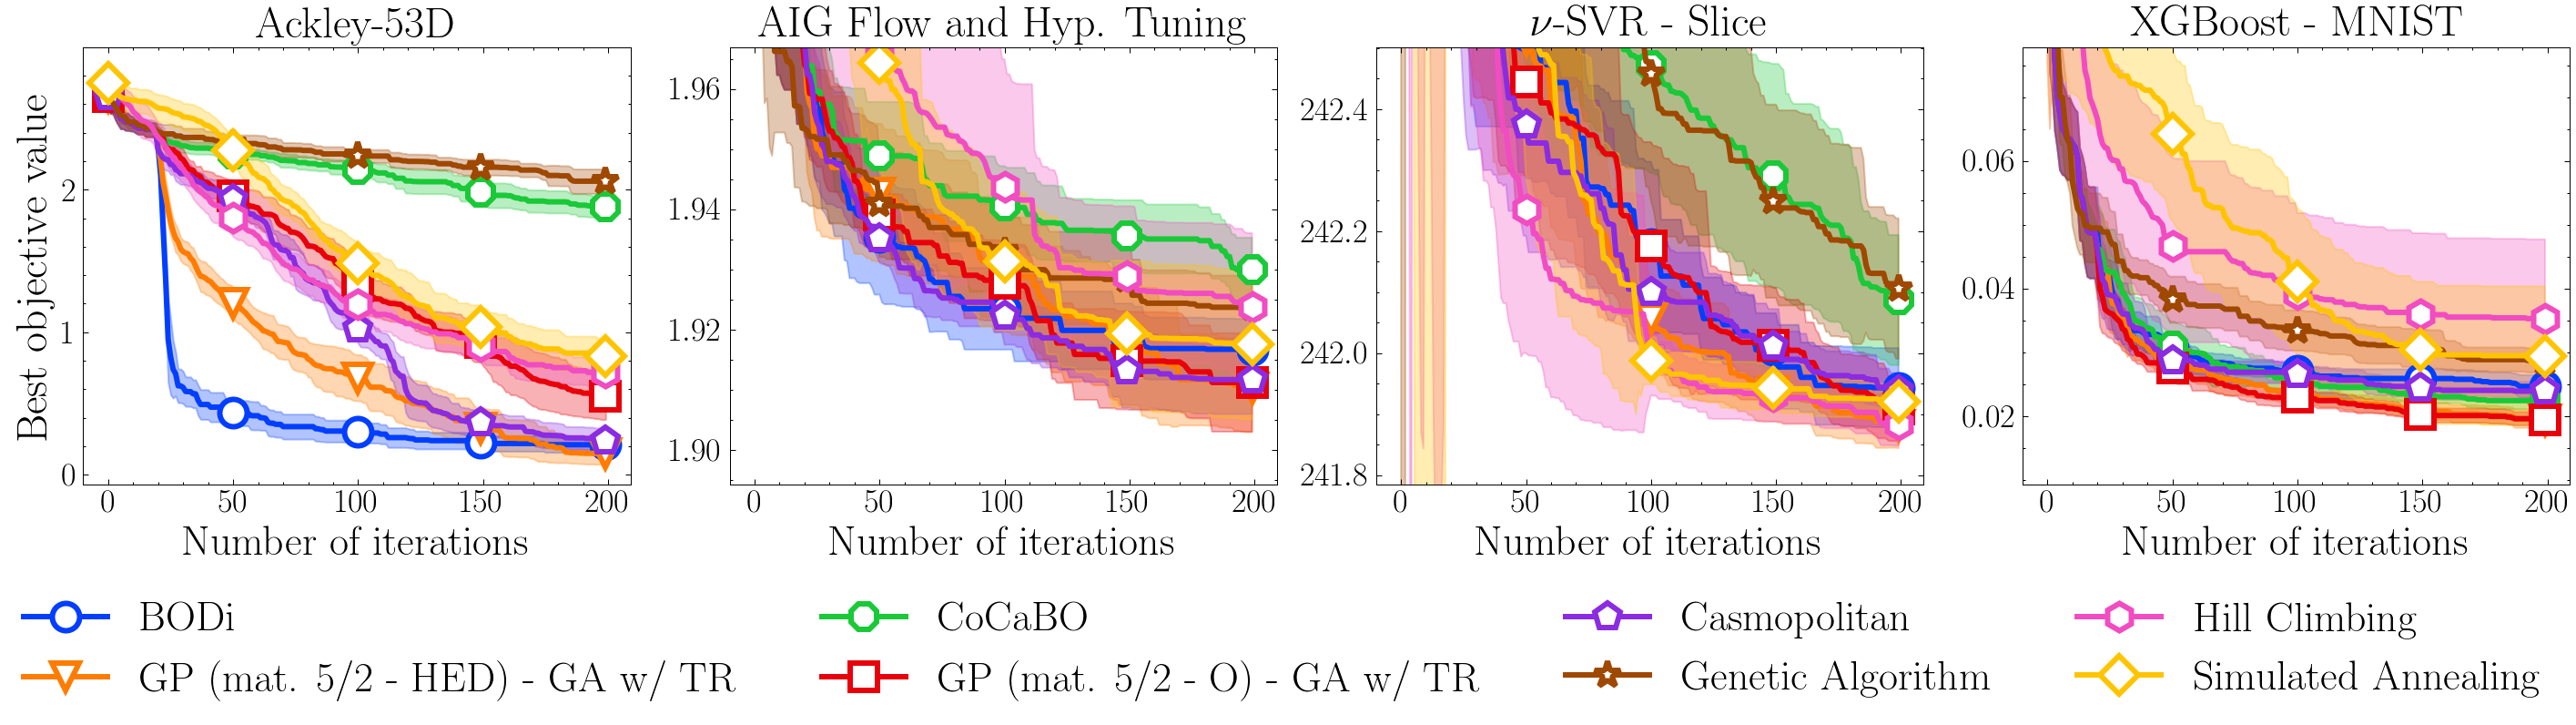

In [42]:
# Grid of subplots when we know n_col and the number of elements to plot
n_el = len(task_ids)

n_col = 4
n_row = np.ceil(n_el / n_col).astype(int)

fig, axes = plt.subplots(n_row, n_col, figsize=(5 * n_col, 5 * n_row))
axes = axes.reshape(n_row, n_col)


ind = 0
for task_id, task_group in all_res.groupby("Task"):
    i_row = ind // n_col
    j_col = ind % n_col
    ax = axes[i_row, j_col]
    
    res_regret_dic = {}
    for opt_name, task_opt_group in task_group.groupby("Optimizer"):
        if opt_name not in selected_algo_names:
            continue
        res = np.array([task_opt_seed_group["f(x*)"].values[x_evals] for _, task_opt_seed_group in task_opt_group.groupby("Seed")])
        res_regret_dic[opt_name] = res
    
    ax = plot_task_regrets(ax=ax, data_x=x_evals, data_y=res_regret_dic, data_color=data_color, data_key_to_label=data_key_to_label,
                      data_marker=data_marker, ci_level=ci_level, show_std_error=False, zoom_end_pct=.7)

    ind += 1
    
    ax.set_title(task_id_to_name(task_id=task_id), fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=18)
    if i_row == (n_row - 1):
        ax.set_xlabel("Number of iterations", fontsize=23)
    if j_col == 0:
        ax.set_ylabel("Best objective value", fontsize=24)
        

handles, labels = ax.get_legend_handles_labels()

n_col_legend = int(np.ceil(len(labels) / 2))
n_bbox = (len(labels) - 1) // n_col_legend + 1
y_bbox = 0.12

lgd = fig.legend(handles, labels, bbox_to_anchor=[.5, y_bbox], loc='upper center', fancybox=True, shadow=True, ncol=n_col_legend, fontsize=23)
fig.tight_layout(rect=(0,.09,1,1))
    
plt.savefig(f"./{figure_save_name}/regret_all_bests.pdf")
plt.show()

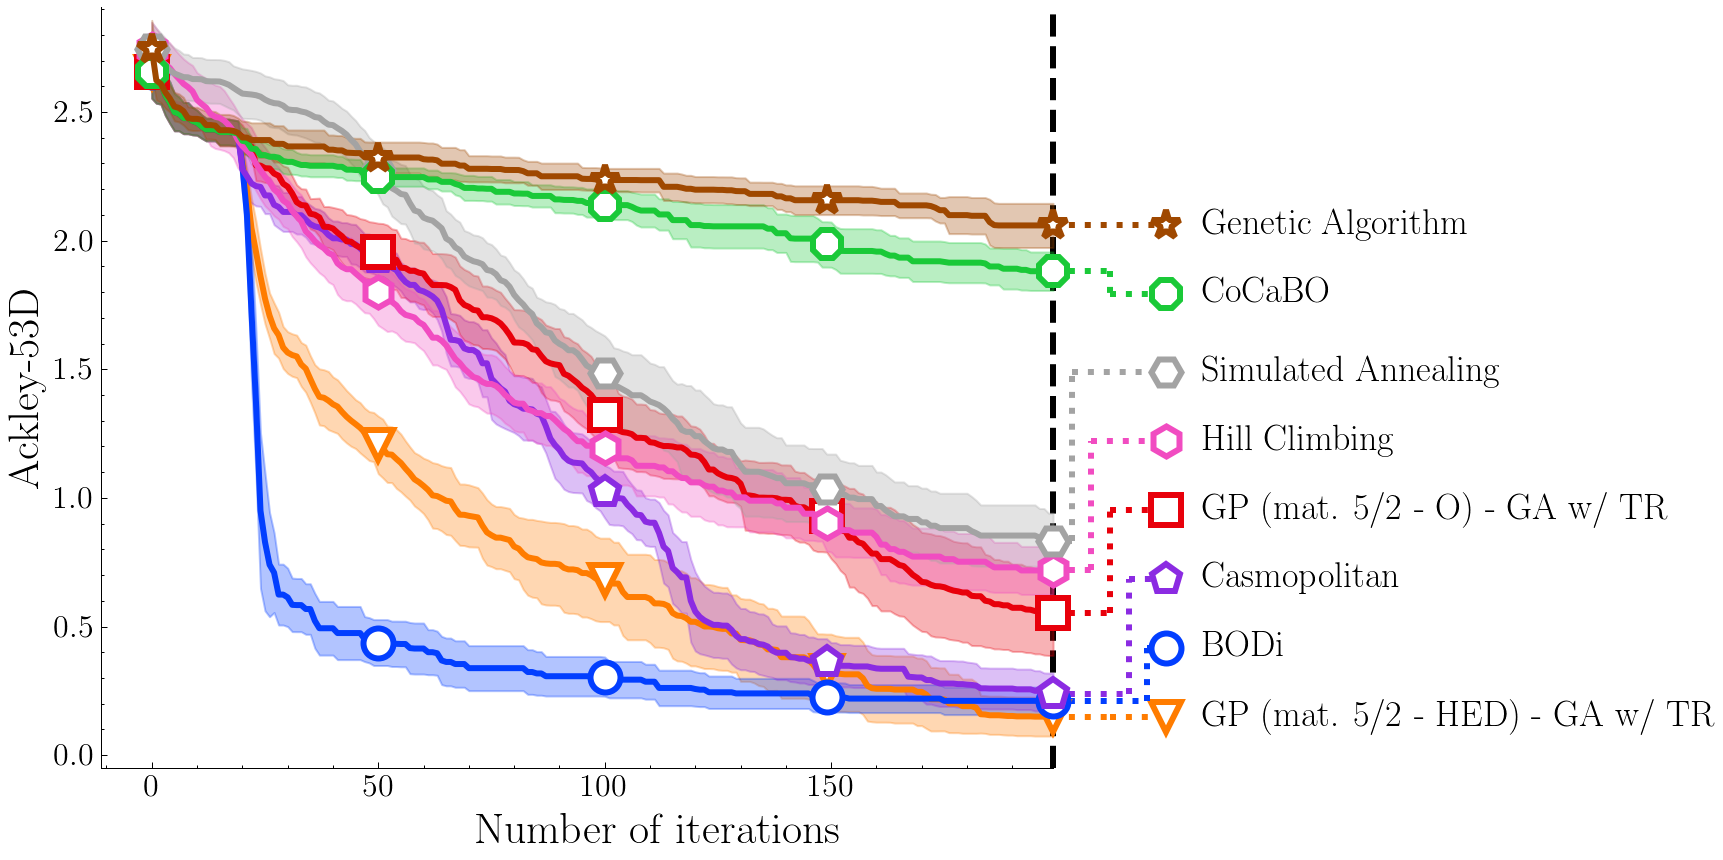

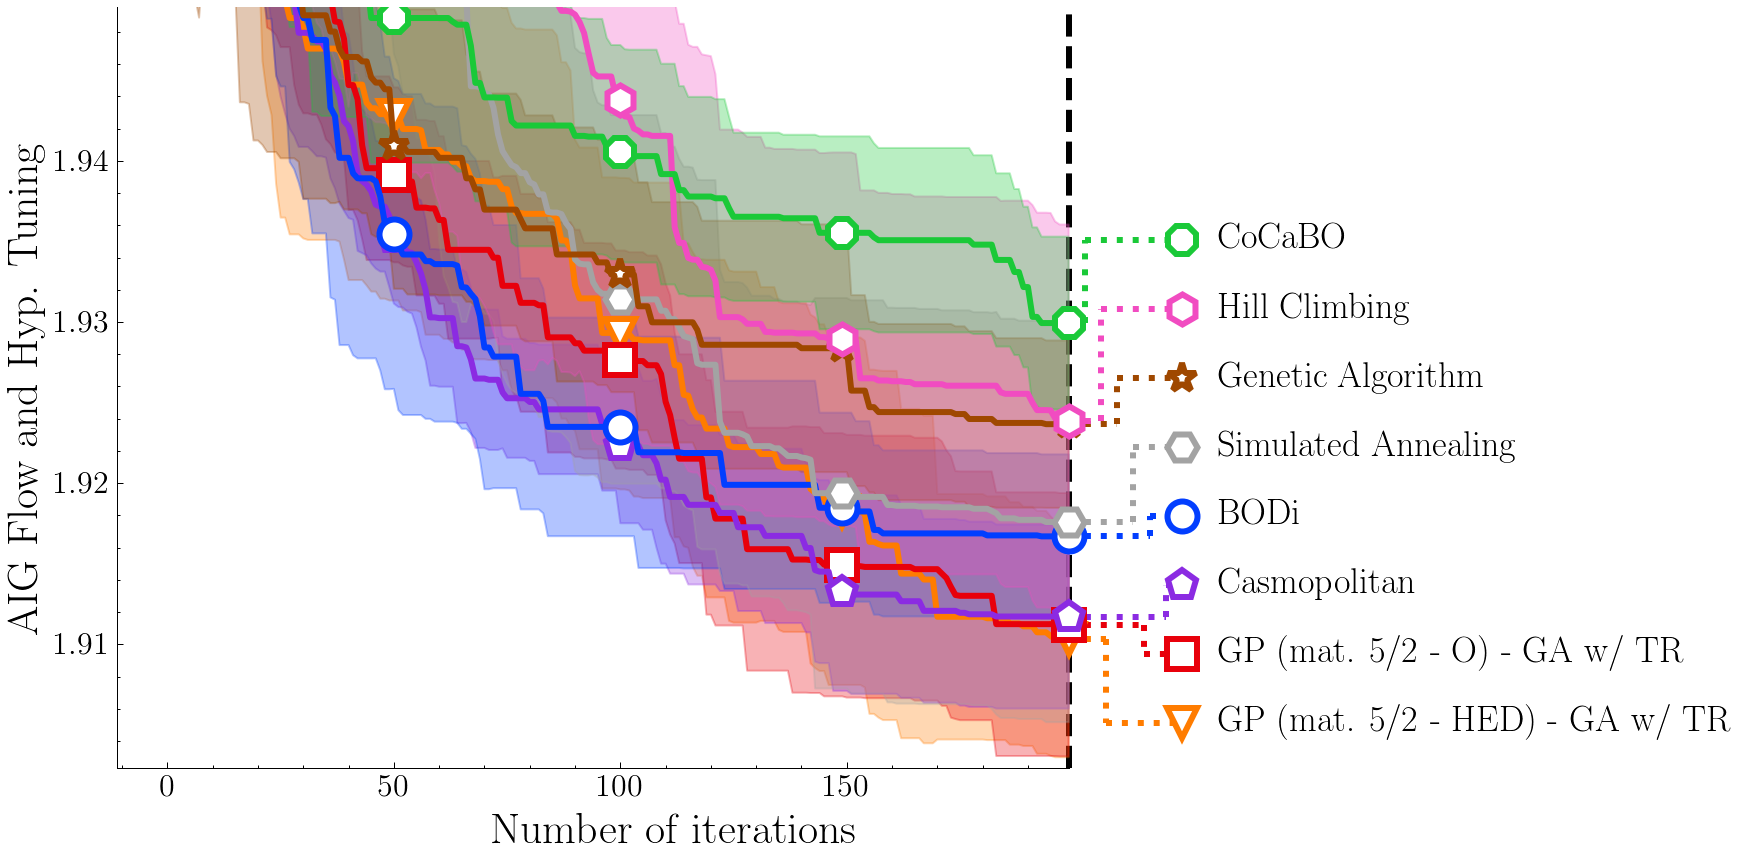

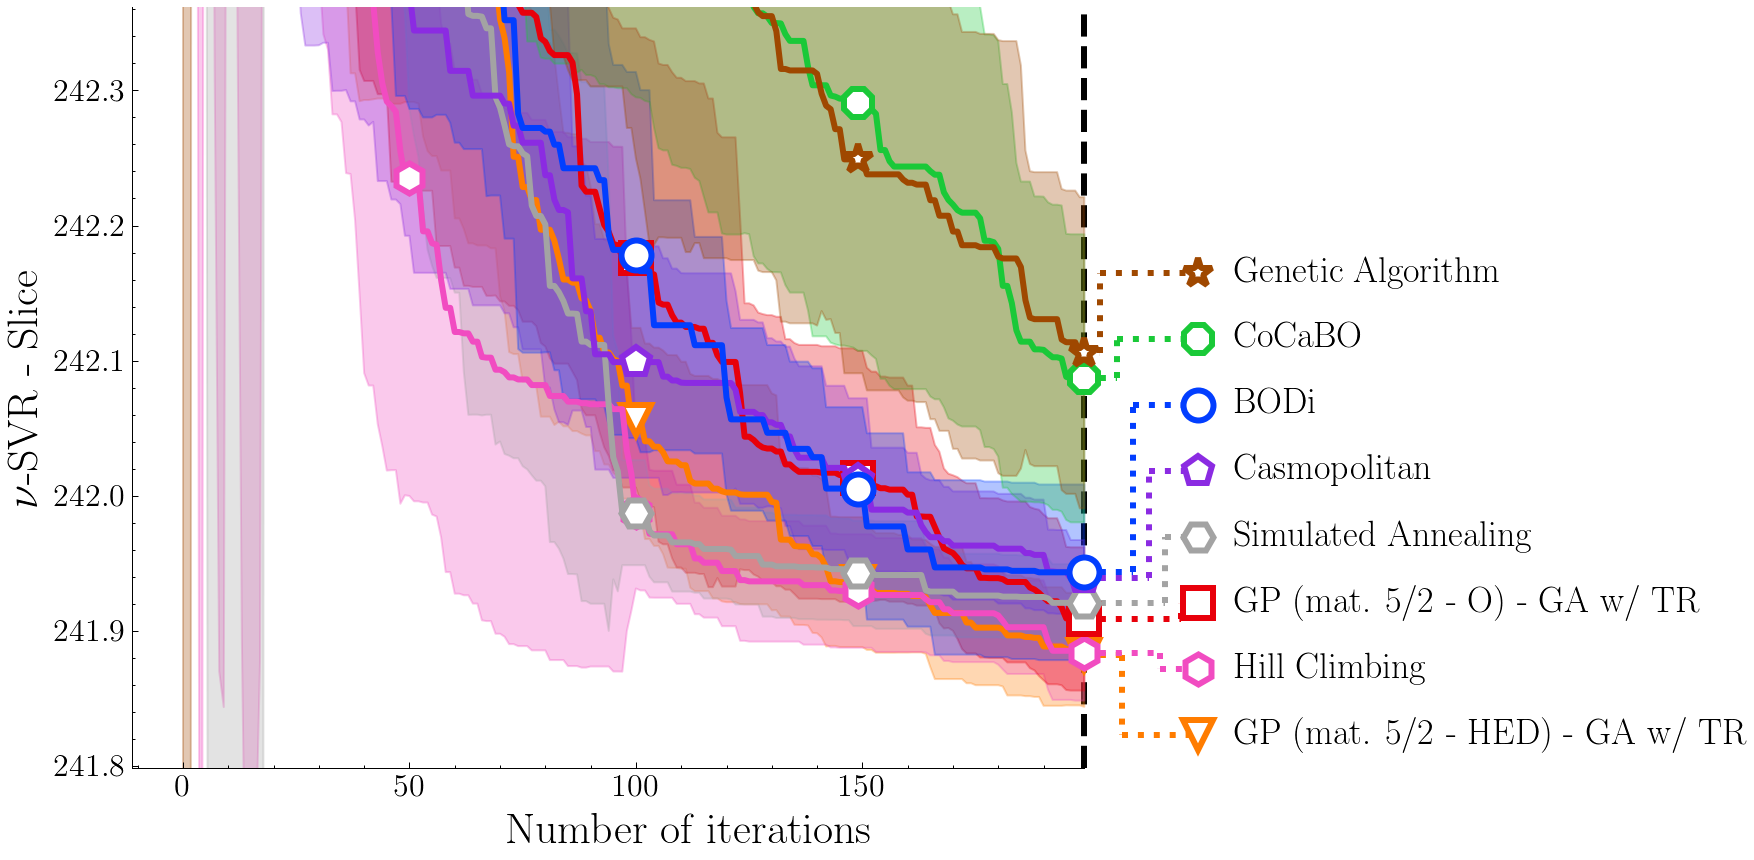

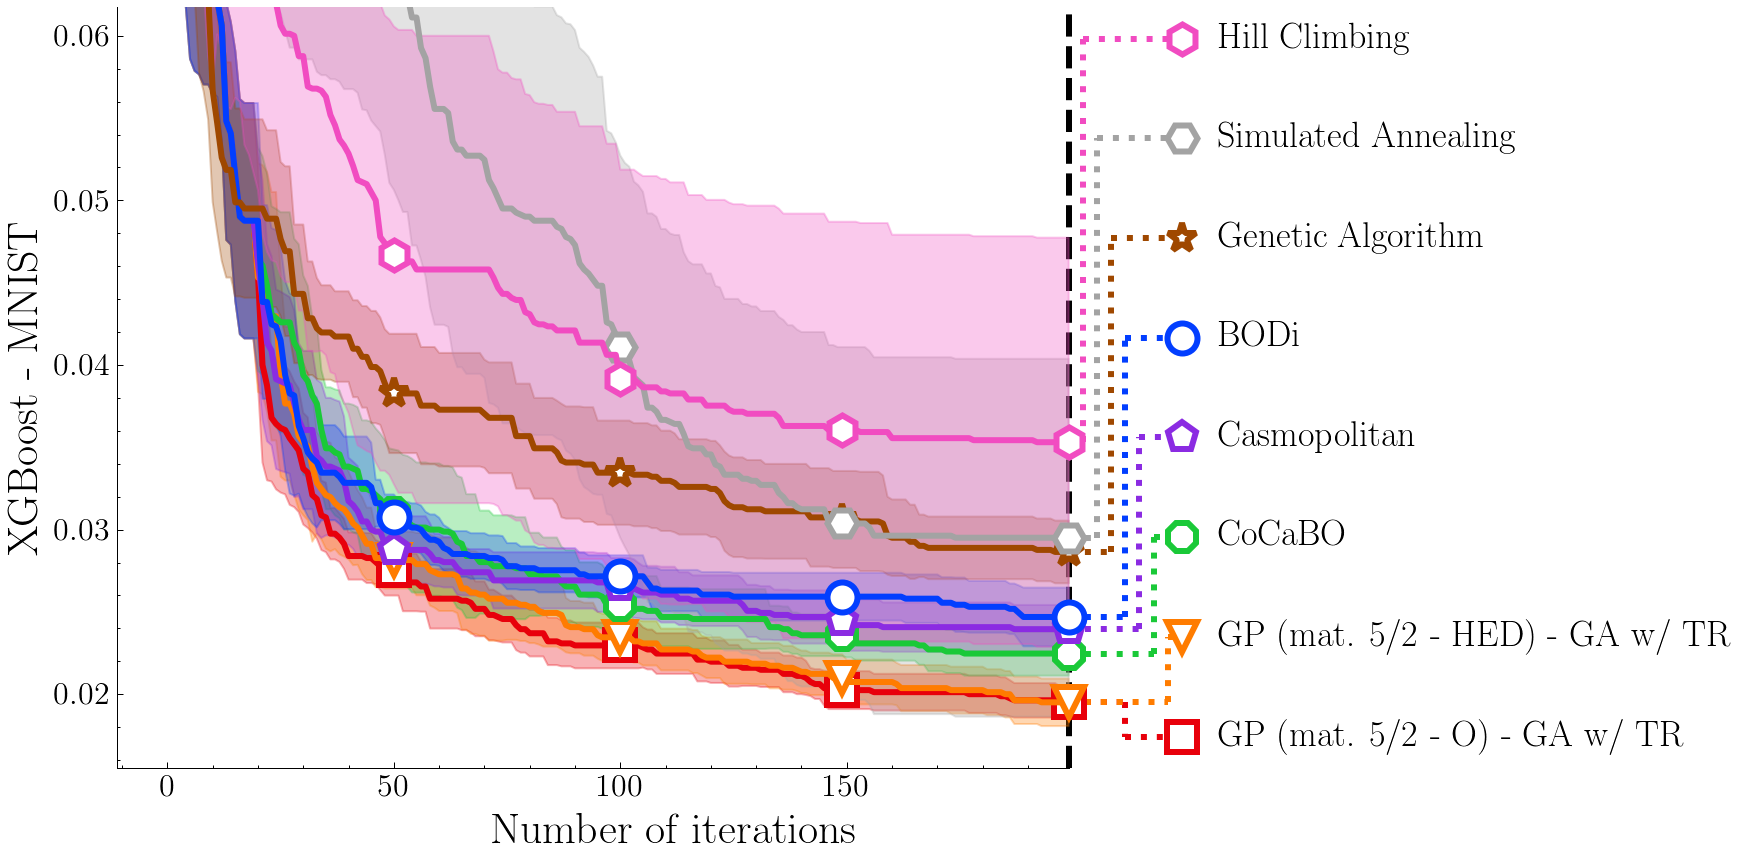

In [43]:
# Grid of subplots when we know n_col and the number of elements to plot
n_el = len(task_ids)

n_col = 2
n_row = np.ceil(n_el / n_col).astype(int)

ind = 0
for task_name, task_group in all_res.groupby("Task"):
    plt.figure(figsize=(10, 7))
    ax = plt.gca()

    res_regret_dic = {}
    for opt_name, task_opt_group in task_group.groupby("Optimizer"):
        if opt_name not in selected_algo_names:
            continue
        res = np.array([task_opt_seed_group["f(x*)"].values[x_evals] for _, task_opt_seed_group in task_opt_group.groupby("Seed")])
        res_regret_dic[opt_name] = res

    plot_curves_with_ranked_legends(ax, data_y=res_regret_dic, data_x=x_evals, data_key_to_label=data_key_to_label, ci_level=.95, zoom_end_pct=.7)
    ind += 1
    
    ax.set_ylabel(task_id_to_name(task_name), fontsize=y_label_fontsize)
    ax.xaxis.set_label_coords(.38, -0.06)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel("Number of iterations", fontsize=22)

#     plt.tight_layout()    
    plt.savefig(f"./{figure_save_name}/regret_{task_name.replace(' ', '_')[:6]}_bests.pdf")
    plt.show()

#### Results aggregated by Model, Acquisition function optimizer, use of TR 

In [44]:
sub_regret_df = all_res.copy()

filtre_out = {"Model": ["no-model"]}

group_col = ["Model"]

for k, v in filtre_out.items():
    sub_regret_df = sub_regret_df[~sub_regret_df[k].isin(v)]

group_col_name = " - ".join(group_col)

sub_regret_df[group_col_name] = sub_regret_df[group_col[0]].values
for i in range(1, len(group_col)): 
    sub_regret_df[group_col_name] += " - " + sub_regret_df[group_col[i]].values

aux_groupby = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])
sub_regret_df["rank"] = aux_groupby[["f(x*)"]].rank()

counts = aux_groupby.count().values.flatten()
assert np.all(counts[0] == counts)

num_cands = counts[0]

In [45]:
num_evals = np.arange(20, 201)

opt_to_rank_dict = {}

sub_regret_df = sub_regret_df.groupby(["Task", "Eval Num", "Seed", group_col_name])["rank"].mean().reset_index()

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["Eval Num"] == num_eval].groupby(group_col_name)["rank"]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T
all_opt_to_rank_dicts["Model"] = opt_to_rank_dict.copy()

###### Assess statistical difference

In [46]:
eval_budget = 200
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["Eval Num"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["Task", "Seed"])["rank"]])

if len(ranks_per_task_seed.T) <= 2:
    print(" At least 3 sets of measurements must be given for Friedman test, got 2")
else:
    friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

    if friedman_test_pvalue >= 0.05:
        print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col="rank", group_col=group_col_name, zero_method="pratt") 
test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

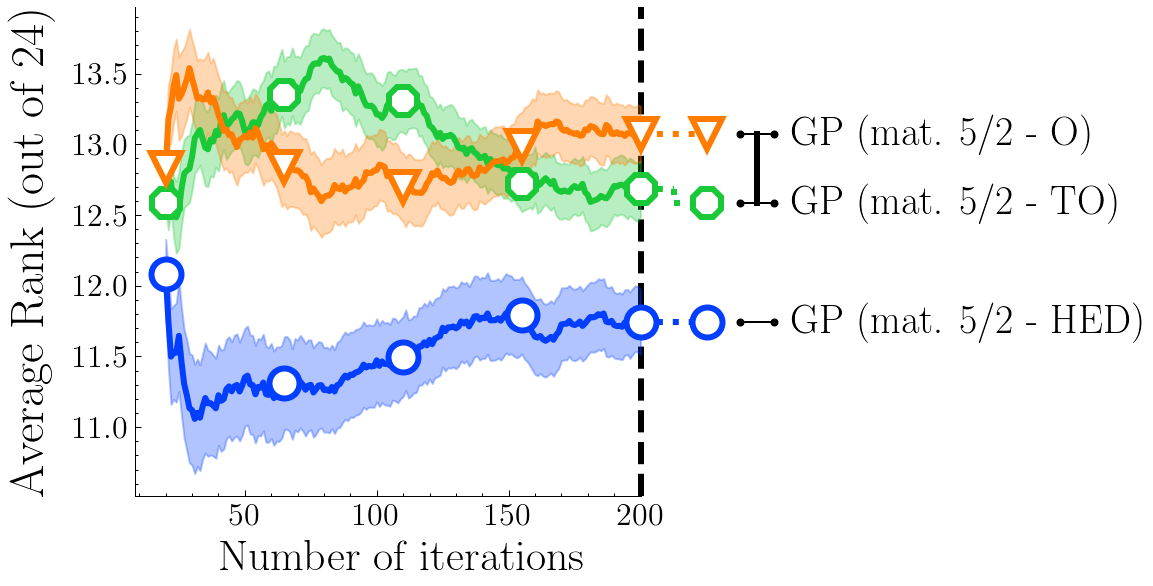

In [47]:
fig, ax = plt.subplots(figsize=(6, 4.5))
plot_curves_with_ranked_legends(
    ax=ax, data_y=opt_to_rank_dict, data_x=num_evals, show_std_error=True, 
    min_is_the_best=True, data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map, label_fontsize=20)

ax.set_ylabel(f"Average Rank (out of {num_cands})", fontsize=24)
ax.set_xlabel("Number of iterations", fontsize=22)
ax.xaxis.set_label_coords(.4, -0.09)
ax.yaxis.set_label_coords(-0.12, .5)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f"./{figure_save_name}/rank_model.pdf")
plt.show()

######  Acq opt

In [48]:
sub_regret_df = all_res.copy()

filtre_out = {"Acq opt": ["no-acq-opt"]}
group_col = ["Acq opt"]

for k, v in filtre_out.items():
    sub_regret_df = sub_regret_df[~sub_regret_df[k].isin(v)]

group_col_name = " - ".join(group_col)

sub_regret_df[group_col_name] = sub_regret_df[group_col[0]].values
for i in range(1, len(group_col)): 
    sub_regret_df[group_col_name] += " - " + sub_regret_df[group_col[i]].values

sub_regret_df["rank"] = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])[["f(x*)"]].rank()

In [49]:
num_evals = np.arange(20, 201)

opt_to_rank_dict = {}

sub_regret_df = sub_regret_df.groupby(["Task", "Eval Num", "Seed", group_col_name])["rank"].mean().reset_index()

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["Eval Num"] == num_eval].groupby(group_col_name)["rank"]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T
all_opt_to_rank_dicts["Acq. Opt."] = opt_to_rank_dict.copy()

###### Assess statistical difference

In [50]:
eval_budget = 200
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["Eval Num"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["Task", "Seed"])["rank"]])

if len(ranks_per_task_seed.T) <= 2:
    print(" At least 3 sets of measurements must be given for Friedman test, got 2")
else:
    friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

    if friedman_test_pvalue >= 0.05:
        print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col="rank", group_col=group_col_name, zero_method="pratt") 
test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

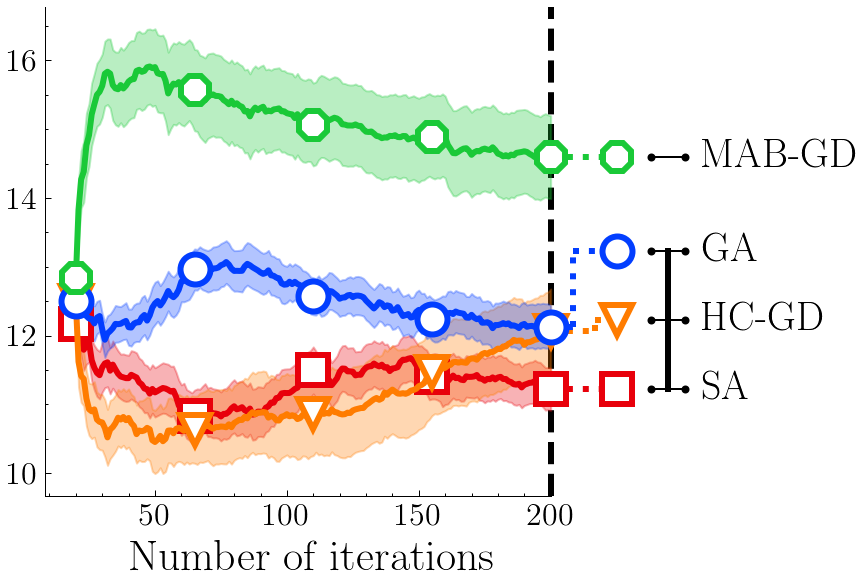

In [51]:
fig, ax = plt.subplots(figsize=(6, 4.5))
plot_curves_with_ranked_legends(
    ax=ax, data_y=opt_to_rank_dict, data_x=num_evals, show_std_error=True, 
    min_is_the_best=True, data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map, label_fontsize=20)

# ax.set_ylabel("Average Rank", fontsize=24)
ax.set_xlabel("Number of iterations", fontsize=22)
ax.xaxis.set_label_coords(.4, -0.09)
ax.yaxis.set_label_coords(-0.12, .5)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f"./{figure_save_name}/rank_acqopt.pdf")

plt.show()

###### Trust Region

In [52]:
sub_regret_df = all_res.copy()

filtre_out = {"Model": ["no-model"]}
group_col = ["TR"]

for k, v in filtre_out.items():
    sub_regret_df = sub_regret_df[~sub_regret_df[k].isin(v)]

group_col_name = " - ".join(group_col)

sub_regret_df[group_col_name] = sub_regret_df[group_col[0]].values
for i in range(1, len(group_col)): 
    sub_regret_df[group_col_name] += " - " + sub_regret_df[group_col[i]].values

sub_regret_df["rank"] = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])[["f(x*)"]].rank()

In [53]:
num_evals = np.arange(20, 201)

opt_to_rank_dict = {}

sub_regret_df = sub_regret_df.groupby(["Task", "Eval Num", "Seed", group_col_name])["rank"].mean().reset_index()

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["Eval Num"] == num_eval].groupby(group_col_name)["rank"]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T
all_opt_to_rank_dicts["TR"] = opt_to_rank_dict.copy()

###### Assess statistical difference

In [54]:
eval_budget = 200
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["Eval Num"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["Task", "Seed"])["rank"]])

if len(ranks_per_task_seed.T) <= 2:
    print(" At least 3 sets of measurements must be given for Friedman test, got 2")
else:
    friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

    if friedman_test_pvalue >= 0.05:
        print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col="rank", group_col=group_col_name, zero_method="pratt") 
test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

 At least 3 sets of measurements must be given for Friedman test, got 2


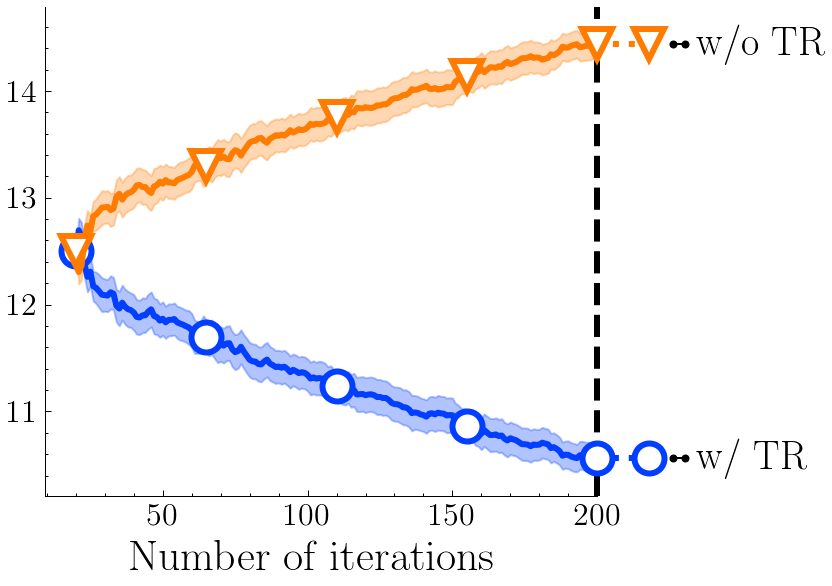

In [55]:
fig, ax = plt.subplots(figsize=(6, 4.5))
plot_curves_with_ranked_legends(
    ax=ax, data_y=opt_to_rank_dict, data_x=num_evals, show_std_error=True, 
    min_is_the_best=True, data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map, label_fontsize=20)

# ax.set_ylabel("Average Rank", fontsize=24)
ax.set_xlabel("Number of iterations", fontsize=22)
ax.xaxis.set_label_coords(.4, -0.09)
ax.yaxis.set_label_coords(-0.12, .5)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f"./{figure_save_name}/rank_tr.pdf")
plt.show()

###### Trust Region and model

In [56]:
sub_regret_df = all_res.copy()

filtre_out = {"Model": ["no-model"]}
group_col = ["TR", "Model"]

for k, v in filtre_out.items():
    sub_regret_df = sub_regret_df[~sub_regret_df[k].isin(v)]

group_col_name = " - ".join(group_col)

sub_regret_df[group_col_name] = sub_regret_df[group_col[0]].values
for i in range(1, len(group_col)): 
    sub_regret_df[group_col_name] += " - " + sub_regret_df[group_col[i]].values

aux_groupby = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])
sub_regret_df["rank"] = aux_groupby[["f(x*)"]].rank()

counts = aux_groupby.count().values.flatten()
assert np.all(counts[0] == counts)

num_cands = counts[0]

In [57]:
num_evals = np.arange(20, 201)

opt_to_rank_dict = {}

sub_regret_df = sub_regret_df.groupby(["Task", "Eval Num", "Seed", group_col_name])["rank"].mean().reset_index()

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["Eval Num"] == num_eval].groupby(group_col_name)["rank"]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T
all_opt_to_rank_dicts["Model and TR"] = opt_to_rank_dict.copy()

###### Assess statistical difference

In [58]:
eval_budget = 200
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["Eval Num"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["Task", "Seed"])["rank"]])

if len(ranks_per_task_seed.T) <= 2:
    print(" At least 3 sets of measurements must be given for Friedman test, got 2")
else:
    friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

    if friedman_test_pvalue >= 0.05:
        print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col="rank", group_col=group_col_name, zero_method="pratt") 
test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

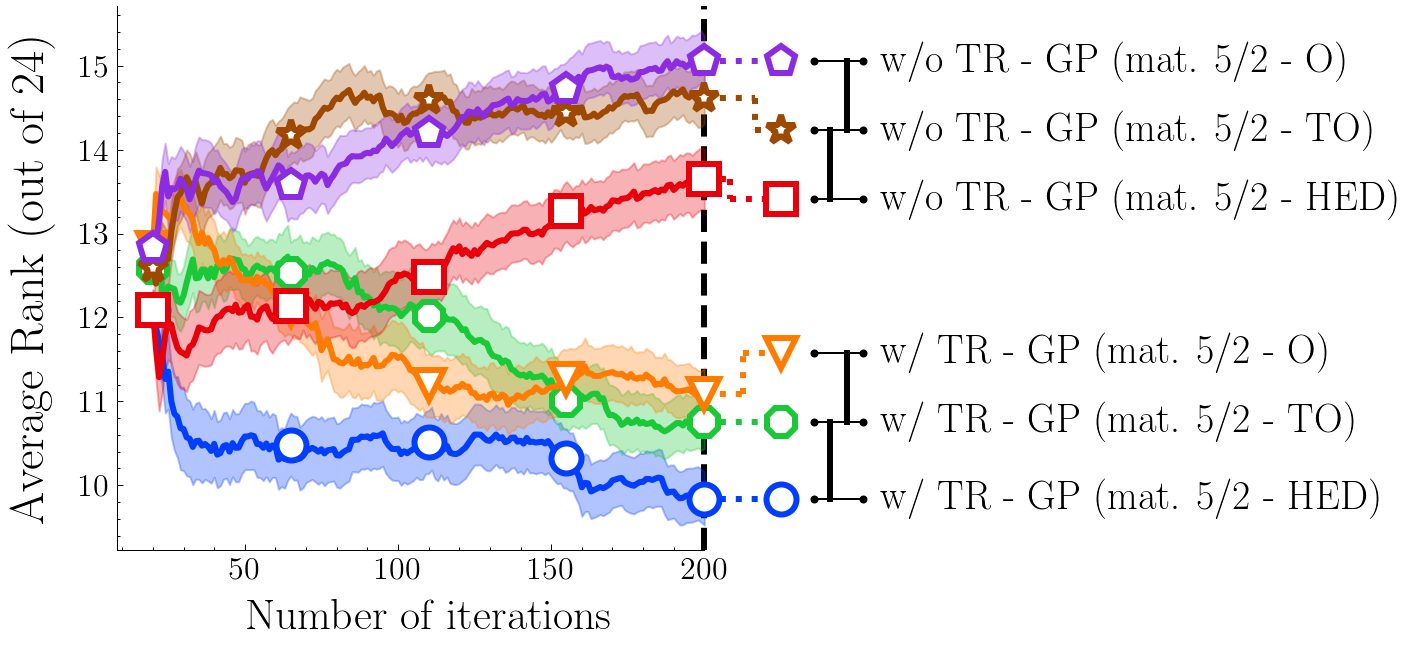

In [59]:
fig, ax = plt.subplots(figsize=(7, 5))
plot_curves_with_ranked_legends(
    ax=ax, data_y=opt_to_rank_dict, data_x=num_evals, show_std_error=True, 
    min_is_the_best=True, data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map, label_fontsize=20)

ax.set_ylabel(f"Average Rank (out of {num_cands})", fontsize=24)
ax.set_xlabel("Number of iterations", fontsize=22)
ax.xaxis.set_label_coords(.4, -0.09)
ax.yaxis.set_label_coords(-0.08, .5)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f"./{figure_save_name}/rank_tr_model.pdf")
plt.show()

###### Trust Region and acq optimization

In [60]:
sub_regret_df = all_res.copy()

filtre_out = {"Model": ["no-model"], "Acq opt": ["no-acq-opt"]}
group_col = ["TR", "Acq opt"]

for k, v in filtre_out.items():
    sub_regret_df = sub_regret_df[~sub_regret_df[k].isin(v)]

group_col_name = " - ".join(group_col)

sub_regret_df[group_col_name] = sub_regret_df[group_col[0]].values
for i in range(1, len(group_col)): 
    sub_regret_df[group_col_name] += " - " + sub_regret_df[group_col[i]].values

aux_groupby = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])
sub_regret_df["rank"] = aux_groupby[["f(x*)"]].rank()

counts = aux_groupby.count().values.flatten()
assert np.all(counts[0] == counts)

num_cands = counts[0]

In [61]:
num_evals = np.arange(20, 201)

opt_to_rank_dict = {}

sub_regret_df = sub_regret_df.groupby(["Task", "Eval Num", "Seed", group_col_name])["rank"].mean().reset_index()

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["Eval Num"] == num_eval].groupby(group_col_name)["rank"]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T
all_opt_to_rank_dicts["Acq. Opt. and TR"] = opt_to_rank_dict.copy()

In [62]:
eval_budget = 200
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["Eval Num"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["Task", "Seed"])["rank"]])

if len(ranks_per_task_seed.T) <= 2:
    print(" At least 3 sets of measurements must be given for Friedman test, got 2")
else:
    friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

    if friedman_test_pvalue >= 0.05:
        print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col="rank", group_col=group_col_name, zero_method="pratt") 
test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

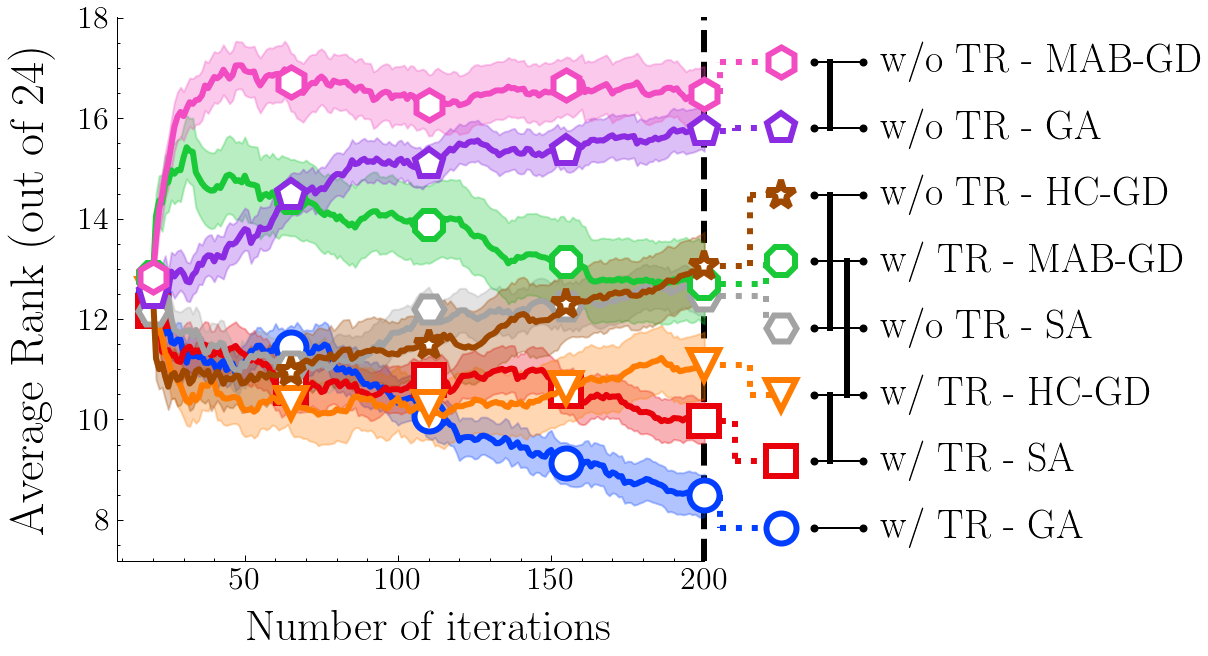

In [63]:
fig, ax = plt.subplots(figsize=(7, 5))
plot_curves_with_ranked_legends(
    ax=ax, data_y=opt_to_rank_dict, data_x=num_evals, show_std_error=True, 
    min_is_the_best=True, data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map, label_fontsize=20)

ax.set_ylabel(f"Average Rank (out of {num_cands})", fontsize=24)
ax.set_xlabel("Number of iterations", fontsize=22)
ax.xaxis.set_label_coords(.4, -0.09)
ax.yaxis.set_label_coords(-0.08, .5)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f"./{figure_save_name}/rank_tr_acq.pdf")
plt.show()

#### Check distribution symmetry

In [64]:
from mcbo.utils.plot_resource_utils import get_color

def plot_check_symmetry(rank_data: Dict[str, np.ndarray], num_eval: int, ax=None):
    if ax is None:
        ax = plt.subplot()

    eval_ind = np.where(num_evals == num_eval)[0][0]
    
    data_colors = [get_color(i) for i in range(len(rank_data))]
    
    order = np.argsort(np.array(list(rank_data.values()))[:, :, eval_ind].mean(-1))
    pos = order.argsort()
    
    violin_parts = ax.violinplot([rank_data[k][:, eval_ind] for k in rank_data], positions = pos, showmeans=True)
    for i, vp in enumerate(violin_parts['bodies']):
        vp.set_facecolor(data_colors[i])
        vp.set_alpha(.3)
        vp.set_edgecolor(data_colors[i])
    
    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = violin_parts[partname]
        vp.set_colors(data_colors)
        vp.set_alpha(1)
        vp.set_linewidth(1)
        
    labels = list(map(data_key_to_label, rank_data.keys()))
    ax.set_xticks(pos, labels=labels, rotation=90, fontsize=24)
    
    ax.tick_params(axis='y', labelsize=16)
    ax.minorticks_off()

    return ax

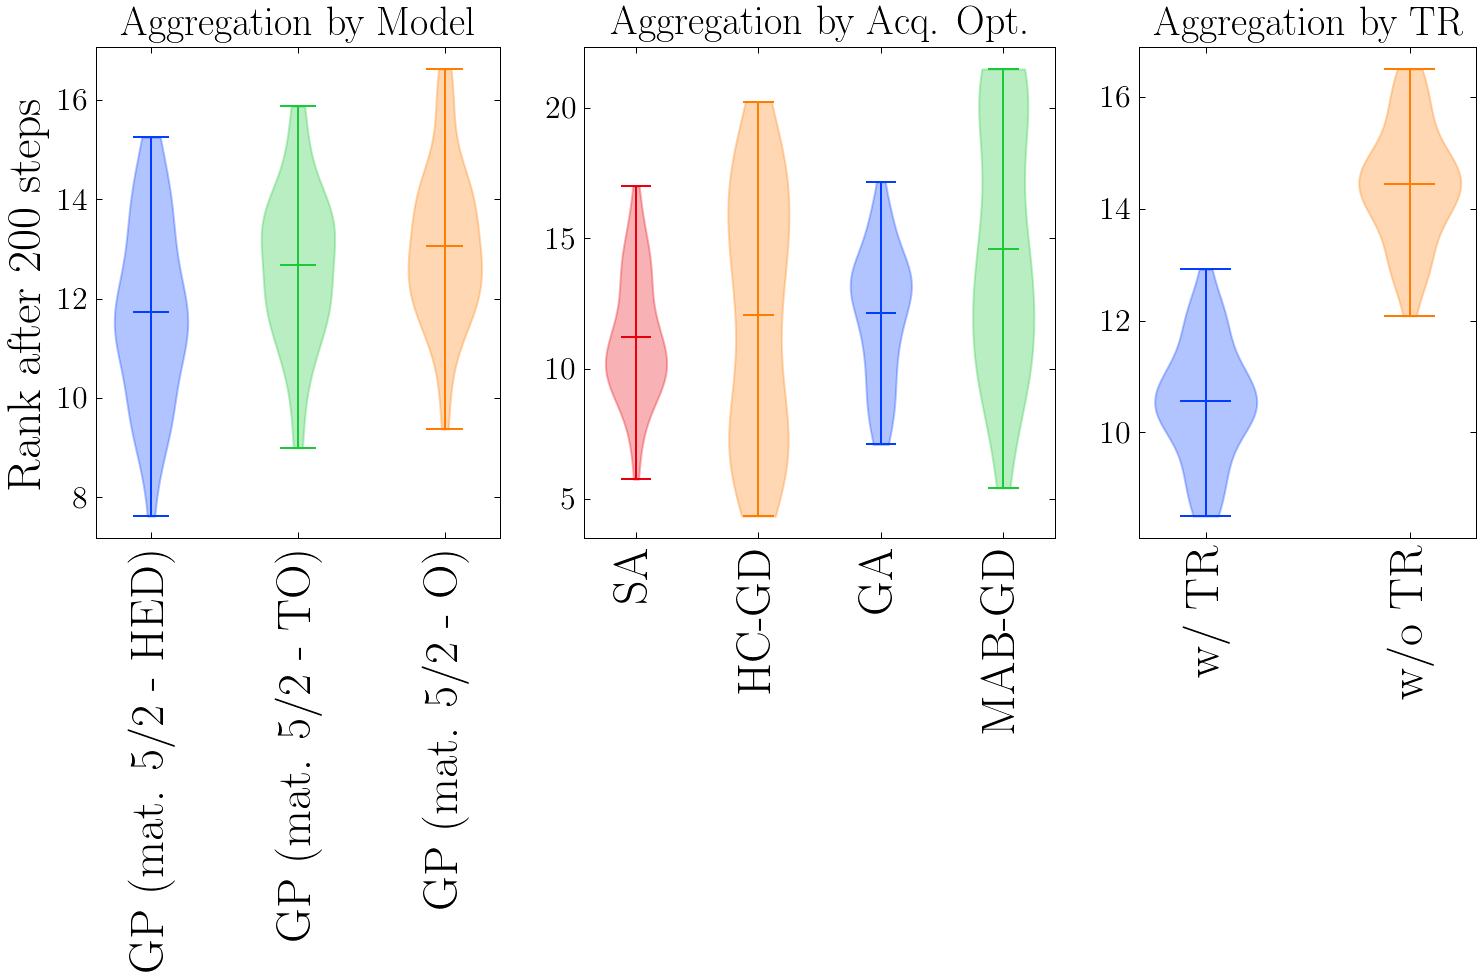

In [69]:
# Grid of subplots when we know n_col and the number of elements to plot
num_eval = 200

selected_aggs = ["Model", "Acq. Opt.", "TR"]

selected_opt_to_rank_dicts = {k: all_opt_to_rank_dicts[k] for k in selected_aggs}

n_el = len(selected_opt_to_rank_dicts)

n_col = 3
n_row = np.ceil(n_el / n_col).astype(int)

n_labels_per_el = np.array([len(ord) for ord in selected_opt_to_rank_dicts.values()]).reshape(n_row, n_col).max(0)

fig, axes = plt.subplots(n_row, n_col, figsize=(sum(n_labels_per_el) / 2 + n_col * 2, 7 * n_row),  width_ratios= 3 + n_labels_per_el)
axes = axes.reshape(n_row, n_col)
    

for ind, agg_var in enumerate(selected_opt_to_rank_dicts):
    i_row = ind // n_col
    j_col = ind % n_col
    ax = axes[i_row, j_col]
    
    ax.set_title(f"Aggregation by {agg_var}", fontsize=20)
    plot_check_symmetry(selected_opt_to_rank_dicts[agg_var], num_eval=num_eval, ax=ax)
    
    if j_col == 0:
        ax.set_ylabel(f"Rank after {num_eval} steps", fontsize=24)
    
plt.tight_layout()    
plt.savefig(f"./{figure_save_name}/check_rank_dist_symmetry_mixed_{'_'.join(map(lambda x: x.replace('. ', ''), selected_aggs))}.pdf")
plt.savefig(f"./{figure_save_name}/check_rank_dist_symmetry_mixed_{'_'.join(map(lambda x: x.replace('. ', ''), selected_aggs))}.pdf")

plt.show()

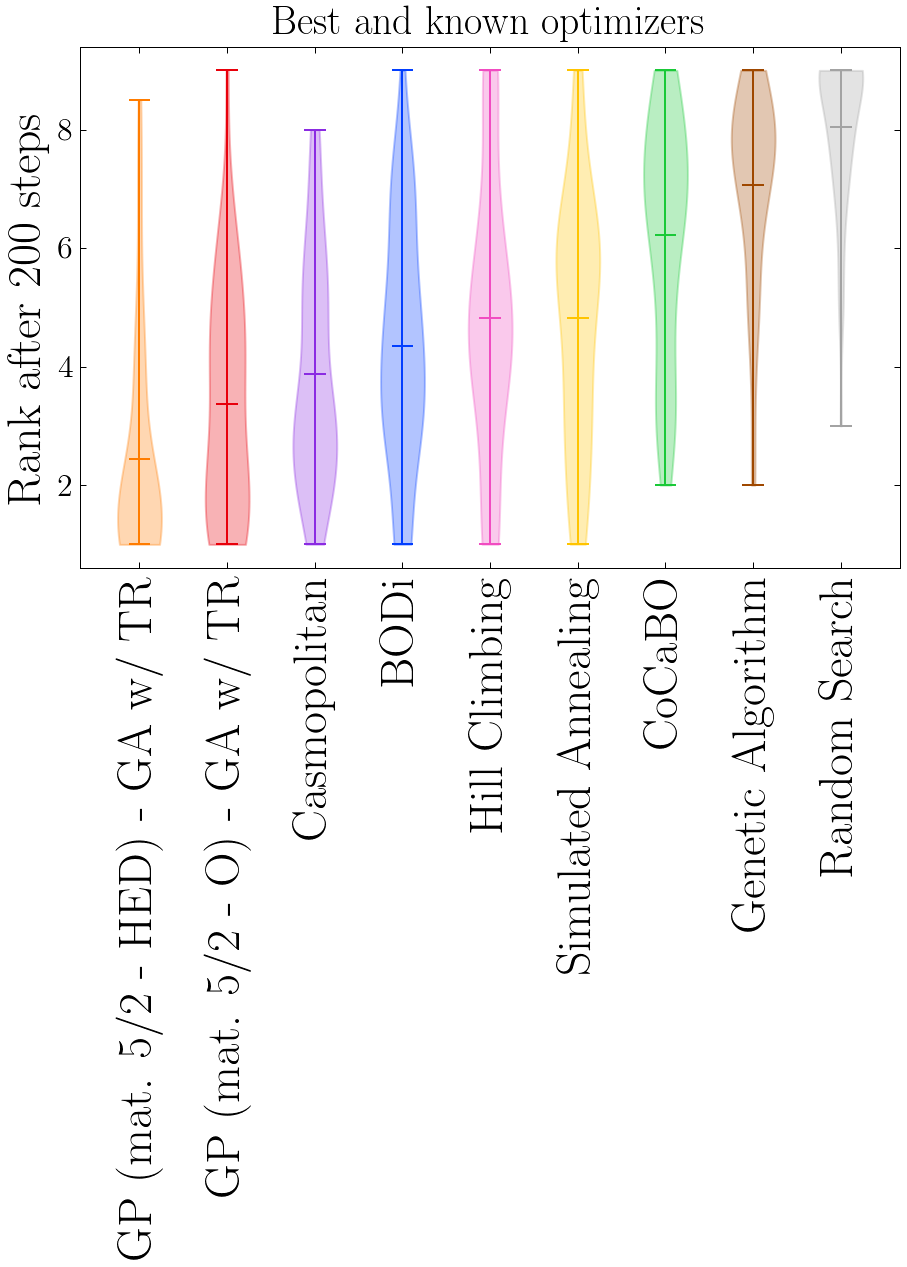

In [70]:
# Grid of subplots when we know n_col and the number of elements to plot
num_eval = 200

selected_aggs = ["None"]

selected_opt_to_rank_dicts = {k: all_opt_to_rank_dicts[k] for k in selected_aggs}

n_el = len(selected_opt_to_rank_dicts)

n_col = min(3, n_el)
n_row = np.ceil(n_el / n_col).astype(int)

n_labels_per_el = np.array([len(ord) for ord in selected_opt_to_rank_dicts.values()]).reshape(n_row, n_col).max(0)

fig, axes = plt.subplots(n_row, n_col, figsize=(sum(n_labels_per_el) / 2 + n_col * 2, 8 + 1 * n_row),  width_ratios= 3 + n_labels_per_el)
if n_col == n_row == 1:
    axes = np.array([axes])
axes = axes.reshape(n_row, n_col)
    

for ind, agg_var in enumerate(selected_opt_to_rank_dicts):
    i_row = ind // n_col
    j_col = ind % n_col
    ax = axes[i_row, j_col]
    
    ax.set_title(f"Best and known optimizers", fontsize=20)
    plot_check_symmetry(selected_opt_to_rank_dicts[agg_var], num_eval=num_eval, ax=ax)
    
    if j_col == 0:
        ax.set_ylabel(f"Rank after {num_eval} steps", fontsize=24)
    
plt.tight_layout()    
plt.savefig(f"./{figure_save_name}/check_rank_dist_symmetry_mixed_{'_'.join(map(lambda x: x.replace('. ', ''), selected_aggs))}.pdf")
plt.savefig(f"./{figure_save_name}/check_rank_dist_symmetry_mixed_{'_'.join(map(lambda x: x.replace('. ', ''), selected_aggs))}.png")
plt.show()

